## 03. 条件变量

通过上两个教程，您学习到了如何定义多参数的配置空间。但在一些特殊的场景，如AutoML场景下，您需要定义一个有条件依赖的空间。这个教程将分为两个部分讲解，1 为分层参数， 2 为条件与禁止语句。

### 层次变量

试想，如果我们定义一个AutoML问题的配置空间，我们不仅要从学习器候选列表中对学习器进行选择，也就是**算法选择**(Algorithm Selection，AS)，还要在选择学习器后对其超参数进行优化，也就是**超参优化**(HyperParameters Optimization, HPO)。

综上，AutoML问题可以定义为算法选择与超参优化问题(Combinaiton of AS and HPO, CASH) [<sup>[1]</sup>](#refer-anchor-1)。

![CASH](https://img-blog.csdnimg.cn/20201223130020129.png)

举个例子，如上图所示[<sup>[2]</sup>](#refer-anchor-2)，分类器我们可以从SVM、LDA、RandomForest等中选择（**算法选择**），如果我们选择了SVM分类器，我们还要对C、Gamma等参数进行优化（**超参优化**），如果Kernel选择了rbf，coeff$_0$参数会被激活$\cdots$

因此，我们需要定义一个分层配置空间。这个分层配置空间可以看成一个有向无环图（DAG），在实际操作中当做树来处理也可以。

我们先按照上图的描述，用HDL定义一个极简的分层配置空间

In [1]:
from ultraopt.hdl import hdl2cs, layering_config, plot_layered_dict, plot_hdl

In [2]:
HDL = {
    "Classifier(choice)":{
        "SVM": {
            "C":  {"_type": "loguniform", "_value": [0.01, 10000], "_default": 1.0},
        },
        "LDA": {
            "n_components":  {"_type": "int_uniform", "_value": [2, 9], "_default": 2},
        }
    }  
}

从上述的HDL定义可以看到，**算法选择变量**需用使用`(choice)`后缀，其值为一个字典，每个键表示候选算法名。

通过 `ultraopt.hdl.plot_hdl`可以对超参可视化：

- **六边形**结点 : 算法选择变量，即后缀为 `(choice)`的变量
- **矩形**结点 : 超参空间，不具备取值范围等实际意义，只起到**容纳超参变量**和**指示算法选择结果**的作用
- **椭圆形**结点 : 超参变量

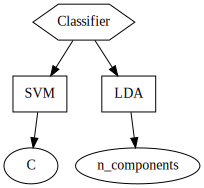

In [3]:
CS = hdl2cs(HDL)
plot_hdl(HDL)

在 `SVM` 这个超参空间内部，还可以继续定义算法选择配置空间。我们用HDL定义更复杂的分层配置空间：

In [4]:
HDL = {
    "Classifier(choice)":{
        "SVM": {
            "C":  {"_type": "loguniform", "_value": [0.01, 10000], "_default": 1.0},
            "kernel(choice)":  {
                "poly": {
                    "degree": {"_type": "int_uniform", "_value": [2, 5], "_default": 3}},
                "rbf": {
                    "coef0": {"_type": "quniform", "_value": [-1, 1], "_default": 0}},
                "sigmoid": {
                    "coef0": {"_type": "quniform", "_value": [-1, 1], "_default": 0}},
            }
        },
        "LDA": {
            "n_components":  {"_type": "int_uniform", "_value": [2, 9], "_default": 2},
            "solver(choice)":  {
                "lsgr": {
                    "shrinkage": {"_type": "choice", "_value": [True, False]}},
                "eigen": {
                    "shrinkage": {"_type": "choice", "_value": [True, False]}},
                "svd": {},
            }
        }
    }  
}

可视化这个HDL

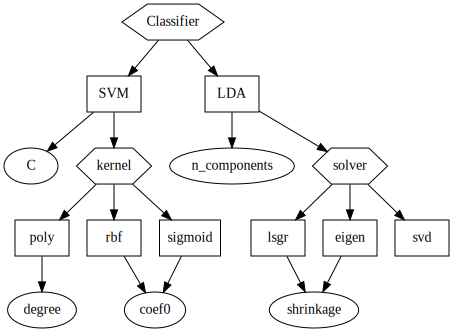

In [5]:
CS = hdl2cs(HDL)
plot_hdl(HDL)

### 配置层次化

我们知道，UltraOpt优化的空间是配置空间(ConfigSpace对象)，用超参描述语言(HDL, dict对象)描述。从这个空间中采样可以得到配置(config, Configuration或dict对象)

现在我们尝试对上文得到的配置空间进行采样：

In [6]:
config = CS.get_default_configuration().get_dictionary() # 获取配置空间的默认配置
config

{'Classifier:__choice__': 'SVM',
 'Classifier:SVM:C': 1.0,
 'Classifier:SVM:kernel:__choice__': 'poly',
 'Classifier:SVM:kernel:poly:degree': 3}

可以看到，这个dict对象的配置是单层的，key的层次用`:`分割。

我们可以用`ultraopt.hdl.layering_config`函数对这个dict对象的`config`进行分层，得到`layered_config`

In [7]:
layered_dict = layering_config(config)

我们可以用`ultraopt.hdl.plot_layered_dict`函数对`layered_config`进行可视化

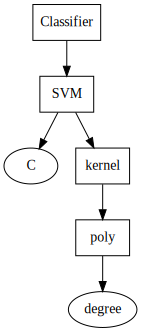

In [8]:
plot_layered_dict(layered_dict)

### 高级条件语句

#### activate 语句

我们希望能更灵活地定义条件超参，比如说我们需要将两个条件超参定义在同一层级中。

以上文的`SVM`为例，我们希望超参`degree`和`coef0`能够与`kernel`同级，但又能保证原有的依赖条件。如图所示：

![sample-layer](https://img-blog.csdnimg.cn/20210103112834860.png)

我们来梳理一下`SVM`中`kernel`与其他变量的的依赖条件是怎样的：

| `kernel` 类型 | 需要使用的参数 | &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; `kernel`公式  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
|--------------|--------------|------------|
| `rbf`|`gamma`| $K\left(\mathbf{x}, \mathbf{x}^{\prime}\right)=\exp \left(-\frac{\left\|\mathbf{x}-\mathbf{x}^{\prime}\right\|^{2}}{2 \sigma^{2}}\right), \gamma=\frac{1}{2 \sigma^{2}}$|
|`sigmoid`|`gamma`, `coef0`|$K\left(\mathbf{x}, \mathbf{x}^{\prime}\right)=sigmoid(\gamma \cdot  \mathbf{x}^T \mathbf{x} + coef_0)$|
|`poly`|`gamma`, `coef0`, `degree`|$K\left(\mathbf{x}, \mathbf{x}^{\prime}\right)=(\gamma \cdot  \mathbf{x}^T \mathbf{x} + coef_0)^{d}$|

通过这个表格，我们不妨将依赖关系想象为激活关系：

- `kernel`=`rbf` $\rightarrow$ 激活 `["gamma"]`

- `kernel`=`sigmoid` $\rightarrow$ 激活 `["gamma", "coef0"]`

- `kernel`=`poly` $\rightarrow$ 激活 `["degree", "gamma", "coef0"]`

于是我们根据这一逻辑，为HDL超参描述语言增加了`activate`激活语句， 编写方法如下：

```python
"__activate": { # 两个下划线开头的都是特殊语句，而不是超参或超参空间的定义
    "激活变量": {
        "激活变量的取值1": [
            # 激活变量 = 激活变量的取值1 时， 被激活的变量
            "被激活的变量1",
            "被激活的变量2",
            ...
        ],
        "激活变量的取值2": ...,
        ...,
    }
}
```

为了让您更好地理解，我们用`activate语句`定义SVM变量间的依赖关系：

In [13]:
HDL_activate = {
    "kernel": {"_type": "choice", "_value": ["rbf", "poly", "sigmoid"], "_default": "rbf"},
    "degree": {"_type": "int_uniform", "_value": [2, 5], "_default": 3},
    "gamma": {"_type": "loguniform", "_value": [1e-05, 8], "_default": 0.1},
    "coef0": {"_type": "quniform", "_value": [-1, 1], "_default": 0},
    "__activate": {
        "kernel": {
            "rbf": ["gamma"],
            "sigmoid": ["gamma", "coef0"],
            "poly": ["degree", "gamma", "coef0"]
        }
    }
}

In [15]:
CS_activate = hdl2cs(HDL_activate)
CS_activate

Configuration space object:
  Hyperparameters:
    coef0, Type: UniformFloat, Range: [-1.0, 1.0], Default: 0.0, Q: 1.0
    degree, Type: UniformInteger, Range: [2, 5], Default: 3
    gamma, Type: UniformFloat, Range: [1e-05, 8.0], Default: 0.1, on log-scale
    kernel, Type: Categorical, Choices: {rbf, poly, sigmoid}, Default: rbf
  Conditions:
    coef0 | kernel in {'poly', 'sigmoid'}
    degree | kernel == 'poly'

我们看看采样得到的样本是否满足`activate语句`：

In [17]:
CS_activate.get_default_configuration()

Configuration:
  gamma, Value: 0.1
  kernel, Value: 'rbf'

可以看到`kernel = rbf`，只能激活`gamma`参数。满足`activate语句`。

同时这个配置空间的所有变量都处在同一层，满足我们的需求：

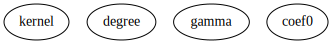

In [18]:
plot_hdl(HDL_activate)

#### condition 语句

我们继续讨论`SVM`这个例子。上文我们从**激活**这个角度思考变量间的关系，但我们能否从**依赖**这个角度来呢？

我们看到：

- 所有的`kernel`取值都会激活`gamma`，所以`gamma`会一直存在。
- `coef0`会在`kernel`取值为`'poly', 'sigmoid'`时被激活。
- `degree`会在`kernel`取值为`poly'`时被激活。

综上，我们为HDL超参描述语言增加了`condition`条件语句， 编写方法如下：

```python
"__condition": [ # 键为"__condition", 值为一个列表， 
    # 每个列表项是一个字典，
    {
        # 字典有 _child, _parent, _values 3个键
        "_child": "coef0",     # 依赖变量
        "_parent": "kernel",   # 被依赖变量
        "_values": ["poly", "sigmoid"],  # 被依赖变量激活依赖变量时的取值
    },
    ...
]
```

为了让您更好地理解，我们用`conditional语句`定义SVM变量间的依赖关系：

In [20]:
HDL_condition = {
    "kernel": {"_type": "choice", "_value": ["rbf", "poly", "sigmoid"], "_default": "rbf"},
    "degree": {"_type": "int_uniform", "_value": [2, 5], "_default": 3},
    "gamma": {"_type": "loguniform", "_value": [1e-05, 8], "_default": 0.1},
    "coef0": {"_type": "quniform", "_value": [-1, 1], "_default": 0},
    "__condition": [
        {
            "_child": "coef0",
            "_parent": "kernel",
            "_values": ["poly", "sigmoid"],
        },
        {
            "_child": "degree",
            "_parent": "kernel",
            "_values": "poly",
        },
    ]
}

In [24]:
CS_conditon = hdl2cs(HDL_condition)
CS_conditon

Configuration space object:
  Hyperparameters:
    coef0, Type: UniformFloat, Range: [-1.0, 1.0], Default: 0.0, Q: 1.0
    degree, Type: UniformInteger, Range: [2, 5], Default: 3
    gamma, Type: UniformFloat, Range: [1e-05, 8.0], Default: 0.1, on log-scale
    kernel, Type: Categorical, Choices: {rbf, poly, sigmoid}, Default: rbf
  Conditions:
    coef0 | kernel in {'poly', 'sigmoid'}
    degree | kernel == 'poly'

两种方法得到的配置空间以一样的：

In [23]:
CS_conditon == CS_activate

True

#### forbidden 语句

如果变量间的取值存在冲突，如在`LinearSVC`中，`penalty == "l1"`且`loss ==  "hinge"`时是非法的，这时我们可以用 `forbidden语句` 定义禁止关系

我们为HDL超参描述语言增加了`forbidden`条件语句， 编写方法如下：

```python
"__forbidden": [ # 键为"__forbidden", 值为一个列表， 
    # 每个列表项是一个字典，
    {
        # 禁止一组变量的共现取值：
        "penalty": "l1",
        "loss": "hinge",
        ...
    },
    ...
]
```

In [25]:
HDL_forbidden = {
    "max_iter": {"_type": "int_quniform", "_value": [300, 3000, 100], "_default": 600},
    "penalty": {"_type": "choice", "_value": ["l1", "l2"], "_default": "l2"},
    "dual": {"_type": "choice", "_value": [True, False], "_default": False},
    "loss": {"_type": "choice", "_value": ["hinge", "squared_hinge"], "_default": "squared_hinge"},
    "C": {"_type": "loguniform", "_value": [0.01, 10000], "_default": 1.0},
    "__forbidden": [
        {"penalty": "l1", "loss": "hinge"},
        {"penalty": "l2", "dual": False, "loss": "hinge"},
        {"penalty": "l1", "dual": False},
        {"penalty": "l1", "dual": True, "loss": "squared_hinge"},
    ]
}                  

In [27]:
CS_forbidden = hdl2cs(HDL_forbidden)
CS_forbidden

Configuration space object:
  Hyperparameters:
    C, Type: UniformFloat, Range: [0.01, 10000.0], Default: 1.0, on log-scale
    dual, Type: Categorical, Choices: {True:bool, False:bool}, Default: True:bool
    loss, Type: Categorical, Choices: {hinge, squared_hinge}, Default: squared_hinge
    max_iter, Type: UniformInteger, Range: [300, 3000], Default: 600, Q: 100
    penalty, Type: Categorical, Choices: {l1, l2}, Default: l2
  Forbidden Clauses:
    (Forbidden: penalty == 'l1' && Forbidden: loss == 'hinge')
    (Forbidden: penalty == 'l2' && Forbidden: dual == 'False:bool' && Forbidden: loss == 'hinge')
    (Forbidden: penalty == 'l1' && Forbidden: dual == 'False:bool')
    (Forbidden: penalty == 'l1' && Forbidden: dual == 'True:bool' && Forbidden: loss == 'squared_hinge')

In [28]:
CS_forbidden.sample_configuration()

Configuration:
  C, Value: 3.915967916341741
  dual, Value: 'True:bool'
  loss, Value: 'hinge'
  max_iter, Value: 1900
  penalty, Value: 'l2'

**参考文献**

---

<div id="refer-anchor-1"></div>

- [1] [Thornton, Chris et al. “Auto-WEKA: combined selection and hyperparameter optimization of classification algorithms.” Proceedings of the 19th ACM SIGKDD international conference on Knowledge discovery and data mining (2013): n. pag.](https://arxiv.org/abs/1208.3719)

<div id="refer-anchor-2"></div>

- [2] [Zoller, Marc-Andre and Marco F. Huber. “Benchmark and Survey of Automated Machine Learning Frameworks.” arXiv: Learning (2019): n. pag.](https://arxiv.org/abs/1904.12054)


